In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import delayed, Parallel

In [2]:
class paths:
    TRAIN = './data/train.csv'
    TEST = './data/test.csv'

# Features

In [21]:
df = pd.read_csv(paths.TRAIN)
df.describe().T

count          mean           std        min  \
id                     19219.0  9.609000e+03  5.548192e+03     0.0000   
X_Minimum              19219.0  7.098547e+02  5.315442e+02     0.0000   
X_Maximum              19219.0  7.538576e+02  4.998366e+02     4.0000   
Y_Minimum              19219.0  1.849756e+06  1.903554e+06  6712.0000   
Y_Maximum              19219.0  1.846605e+06  1.896295e+06  6724.0000   
Pixels_Areas           19219.0  1.683988e+03  3.730320e+03     6.0000   
X_Perimeter            19219.0  9.565466e+01  1.778214e+02     2.0000   
Y_Perimeter            19219.0  6.412410e+01  1.010542e+02     1.0000   
Sum_of_Luminosity      19219.0  1.918467e+05  4.420247e+05   250.0000   
Minimum_of_Luminosity  19219.0  8.480842e+01  2.880034e+01     0.0000   
Maximum_of_Luminosity  19219.0  1.286474e+02  1.419698e+01    39.0000   
Length_of_Conveyer     19219.0  1.459351e+03  1.455687e+02  1227.0000   
TypeOfSteel_A300       19219.0  4.026744e-01  4.904490e-01     0.0000   
TypeOfSteel_A400       19219.0  5.963370e-01  4.906442e-01     0.0000   
Steel_Plate_Thickness  19219.0  7.621312e+01  5.393196e+01    40.0000   
Edges_Index            19219.0  3.529394e-01  3.189760e-01     0.0000   
Empty_Index            19219.0  4.093095e-01  1.241435e-01     0.0000   
Square_Index           19219.0  5.745204e-01  2.594359e-01     0.0083   
Outside_X_Index        19219.0  3.060936e-02  4.730194e-02     0.0015   
Edges_X_Index          19219.0  6.147495e-01  2.223913e-01     0.0144   
Edges_Y_Index          19219.0  8.316521e-01  2.209660e-01     0.1050   
Outside_Global_Index   19219.0  5.918986e-01  4.820500e-01     0.0000   
LogOfAreas             19219.0  2.473475e+00  7.605751e-01     0.7782   
Log_X_Index            19219.0  1.312667e+00  4.678477e-01     0.3010   
Log_Y_Index            19219.0  1.389737e+00  4.055493e-01     0.0000   
Orientation_Index      19219.0  1.027423e-01  4.876805e-01    -0.9884   
Luminosity_Index       19219.0 -1.383818e-01  1.203440e-01    -0.8850   
SigmoidOfAreas         19219.0  5.719022e-01  3.322186e-01     0.1190   
Pastry                 19219.0  7.627868e-02  2.654504e-01     0.0000   
Z_Scratch              19219.0  5.983662e-02  2.371901e-01     0.0000   
K_Scatch               19219.0  1.785733e-01  3.830046e-01     0.0000   
Stains                 19219.0  2.955409e-02  1.693580e-01     0.0000   
Dirtiness              19219.0  2.523544e-02  1.568435e-01     0.0000   
Bumps                  19219.0  2.478277e-01  4.317625e-01     0.0000   
Other_Faults           19219.0  3.412248e-01  4.741330e-01     0.0000   

                                25%           50%           75%           max  
id                       4804.50000  9.609000e+03  1.441350e+04  1.921800e+04  
X_Minimum                  49.00000  7.770000e+02  1.152000e+03  1.705000e+03  
X_Maximum                 214.00000  7.960000e+02  1.165000e+03  1.713000e+03  
Y_Minimum              657468.00000  1.398169e+06  2.368032e+06  1.298766e+07  
Y_Maximum              657502.00000  1.398179e+06  2.362511e+06  1.298769e+07  
Pixels_Areas               89.00000  1.680000e+02  6.530000e+02  1.526550e+05  
X_Perimeter                15.00000  2.500000e+01  6.400000e+01  7.553000e+03  
Y_Perimeter                14.00000  2.300000e+01  6.100000e+01  9.030000e+02  
Sum_of_Luminosity        9848.00000  1.823800e+04  6.797800e+04  1.159141e+07  
Minimum_of_Luminosity      70.00000  9.000000e+01  1.050000e+02  1.960000e+02  
Maximum_of_Luminosity     124.00000  1.270000e+02  1.350000e+02  2.530000e+02  
Length_of_Conveyer       1358.00000  1.364000e+03  1.652000e+03  1.794000e+03  
TypeOfSteel_A300            0.00000  0.000000e+00  1.000000e+00  1.000000e+00  
TypeOfSteel_A400            0.00000  1.000000e+00  1.000000e+00  1.000000e+00  
Steel_Plate_Thickness      40.00000  6.900000e+01  8.000000e+01  3.000000e+02  
Edges_Index                 0.05860  2.385000e-01  6.561000e-01  9.952000e-01  
Empty_Index                 0.31750 

## Targets

In [22]:
y_cols = df.columns[-7:]

In [23]:
display(df[y_cols].sum(axis=1).value_counts().sort_index())

0      818
1    18380
2       21
Name: count, dtype: int64

Since there are a significant number of non-defective steel plates, we'll create a new target: `No Defect`. This is not a true target, so it will not contribute to our mean AUROC score. We'll also drop the 21 datapoints that have 2 defects since they are a significant minority (~ 0.1%).

In [24]:
df['Sum Targets'] = df[y_cols].sum(axis=1)
df['No Defect'] = (df['Sum Targets'] == 0).astype('int')
df = df.loc[df['Sum Targets'] < 2]
y_cols = [*y_cols, 'No Defect']
df = df.drop(columns=['Sum Targets'])
display(df[y_cols].sum(axis=1).value_counts().sort_index())

1    19198
Name: count, dtype: int64

In [25]:
feature_df = df.drop(columns=y_cols)
feature_df['Height'] = np.abs(feature_df['Y_Maximum'] - feature_df['Y_Minimum'])
feature_df['Width'] = np.abs(feature_df['X_Maximum'] - feature_df['X_Minimum'])
feature_df.drop(columns=['X_Maximum', 'X_Minimum', 'Y_Maximum', 'Y_Minimum', 
                         'id', 'SigmoidOfAreas', 'Pixels_Areas'], inplace=True)
feature_df.describe().T

count           mean            std        min  \
X_Perimeter            19198.0      95.119752     176.986712     2.0000   
Y_Perimeter            19198.0      63.807480     100.542676     1.0000   
Sum_of_Luminosity      19198.0  190786.232055  440685.200500   250.0000   
Minimum_of_Luminosity  19198.0      84.853683      28.767828     0.0000   
Maximum_of_Luminosity  19198.0     128.635587      14.195211    39.0000   
Length_of_Conveyer     19198.0    1459.402281     145.624301  1227.0000   
TypeOfSteel_A300       19198.0       0.403115       0.490536     0.0000   
TypeOfSteel_A400       19198.0       0.595947       0.490721     0.0000   
Steel_Plate_Thickness  19198.0      76.251693      53.948649    40.0000   
Edges_Index            19198.0       0.353208       0.318992     0.0000   
Empty_Index            19198.0       0.409177       0.124096     0.0000   
Square_Index           19198.0       0.574261       0.259337     0.0083   
Outside_X_Index        19198.0       0.030530       0.047247     0.0015   
Edges_X_Index          19198.0       0.615103       0.222205     0.0144   
Edges_Y_Index          19198.0       0.832035       0.220705     0.1050   
Outside_Global_Index   19198.0       0.591687       0.482093     0.0000   
LogOfAreas             19198.0       2.471962       0.759366     0.7782   
Log_X_Index            19198.0       1.311872       0.467275     0.3010   
Log_Y_Index            19198.0       1.388927       0.404930     0.0000   
Orientation_Index      19198.0       0.102735       0.487856    -0.9884   
Luminosity_Index       19198.0      -0.138416       0.120358    -0.8850   
Height                 19198.0   38019.788624  467401.272386     0.0000   
Width                  19198.0      44.929889      79.340174     0.0000   

                             25%         50%           75%           max  
X_Perimeter              15.0000     25.0000     64.000000  7.553000e+03  
Y_Perimeter              14.0000     23.0000     60.750000  9.030000e+02  
Sum_of_Luminosity      9791.0000  18218.0000  67950.500000  1.159141e+07  
Minimum_of_Luminosity    70.0000     90.0000    105.000000  1.960000e+02  
Maximum_of_Luminosity   124.0000    127.0000    135.000000  2.530000e+02  
Length_of_Conveyer     1358.0000   1364.0000   1652.000000  1.794000e+03  
TypeOfSteel_A300          0.0000      0.0000      1.000000  1.000000e+00  
TypeOfSteel_A400          0.0000      1.0000      1.000000  1.000000e+00  
Steel_Plate_Thickness    40.0000     69.0000     80.000000  3.000000e+02  
Edges_Index               0.0591      0.2390      0.656100  9.952000e-01  
Empty_Index               0.3175      0.4133      0.494475  9.275000e-01  
Square_Index              0.3757      0.5454      0.818200  1.000000e+00  
Outside_X_Index           0.0066      0.0095      0.019100  6.651000e-01  
Edges_X_Index             0.4524      0.6364      0.785700  1.000000e+00  
Edges_Y_Index             0.6579      0.9643      1.000000  1.000000e+00  
Outside_Global_Index      0.0000      1.0000      1.000000  1.000000e+00  
LogOfAreas                1.9494      2.2253      2.814200  4.554300e+00  
Log_X_Index               1.0000      1.1461      1.431400  2.997300e+00  
Log_Y_Index               1.0792      1.3222      1.707600  4.033300e+00  
Orientation_Index        -0.2727      0.1111      0.529400  9.917000e-01  
Luminosity_Index         -0.1925     -0.1427     -0.084000  6.421000e-01  
Height                   12.0000     21.0000     58.000000  1.231342e+07  
Width                    10.0000     14.0000     27.000000  1.665000e+03

For a tree-based model, transformations of numerical columns that preserve the ordering do change nothing. So, we drop `SigmoidOfAreas` and `Pixels_Areas` in favor of `LogOfAreas` for its superior distribution.

## Exploring Geometric Variables

### Width Variables

I'm curious about the meanings of the geometric information. 

`Orientation_Index` ranges from around -1 and 1, so it's likely the cosine or sine of some angle. This angle is almost certainly the angle of the picture being taken, an important corrective variable we'll experiment with during feature engineering.

`X_Perimeter`, `Outside_X_Index`, `Edges_X_Index`, `Log_X_Index`, and `Width` seem like synonyms, so we will run a quick visualization here to see how they relate.

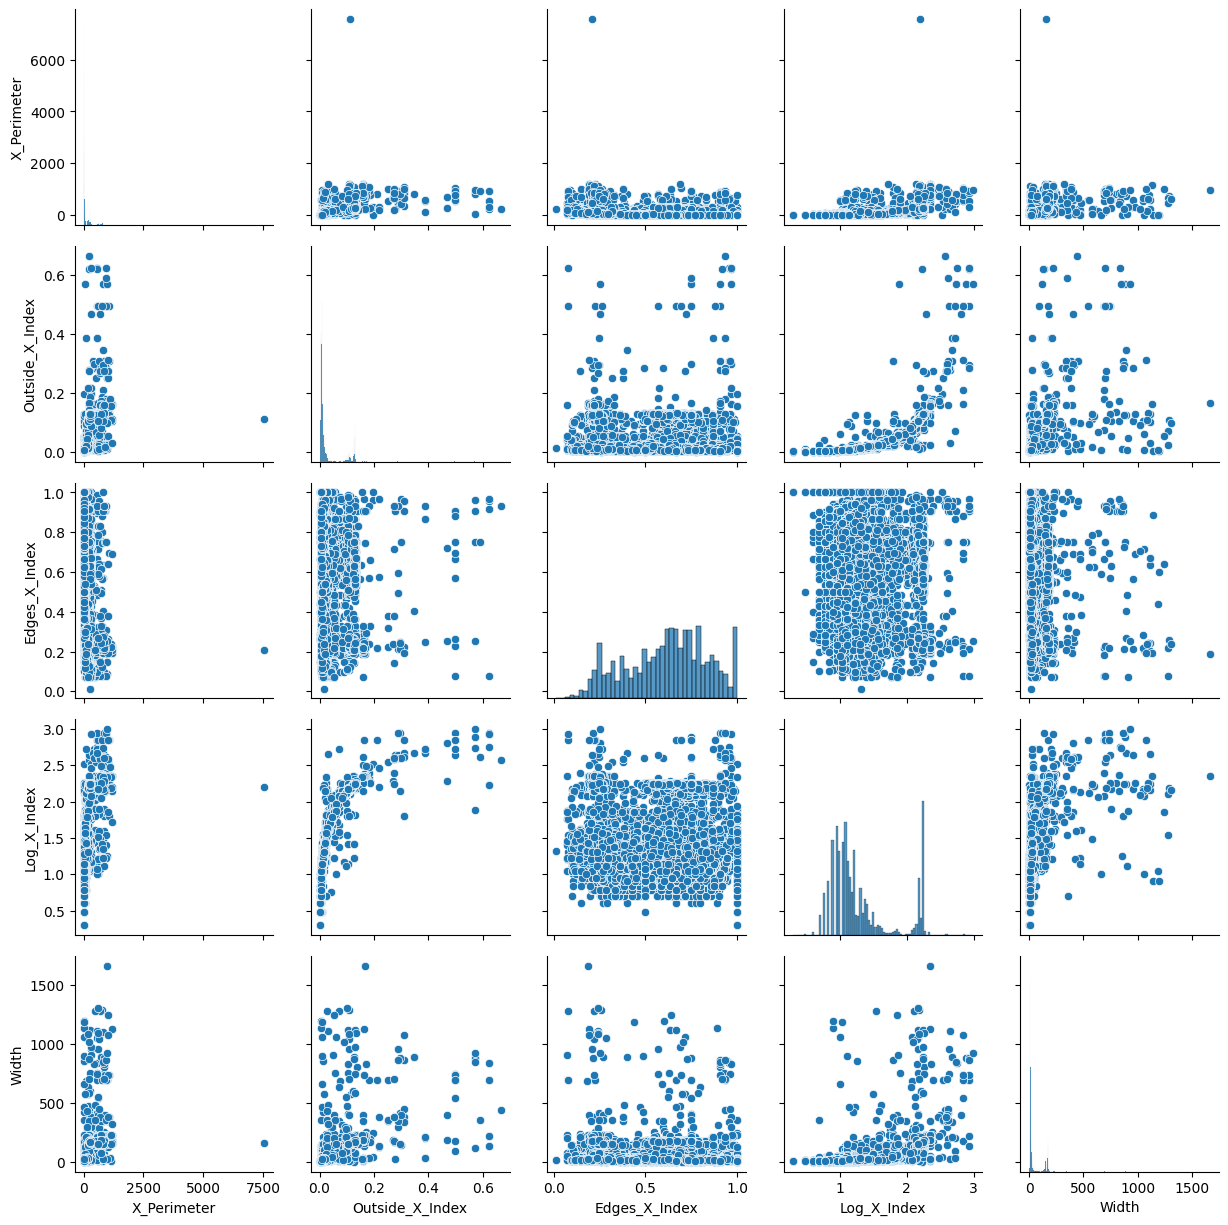

In [26]:
X_feats = feature_df[['X_Perimeter', 'Outside_X_Index', 'Edges_X_Index', 'Log_X_Index', 'Width']]

graph = sns.PairGrid(X_feats)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

Let's investigate the strange `X_Perimeter` outlier.

In [27]:
perimeter_outlier = df.loc[df['X_Perimeter'] > 2500]
display(perimeter_outlier)

id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
10907  10907         41        197    1831860    1832017         10880   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
10907         7553          409            1245114                     40   

       ...  Luminosity_Index  SigmoidOfAreas  Pastry  Z_Scratch  K_Scatch  \
10907  ...           -0.1059             1.0       0          0         1   

       Stains  Dirtiness  Bumps  Other_Faults  No Defect  
10907       0          0      0             0          0  

[1 rows x 36 columns]

This outlier must be a fluke. Let's just drop it from the dataset.

In [28]:
X_feats.drop(labels=10907, inplace=True)

C:\Users\ttfee\AppData\Local\Temp\ipykernel_10756\1575770979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feats.drop(labels=10907, inplace=True)


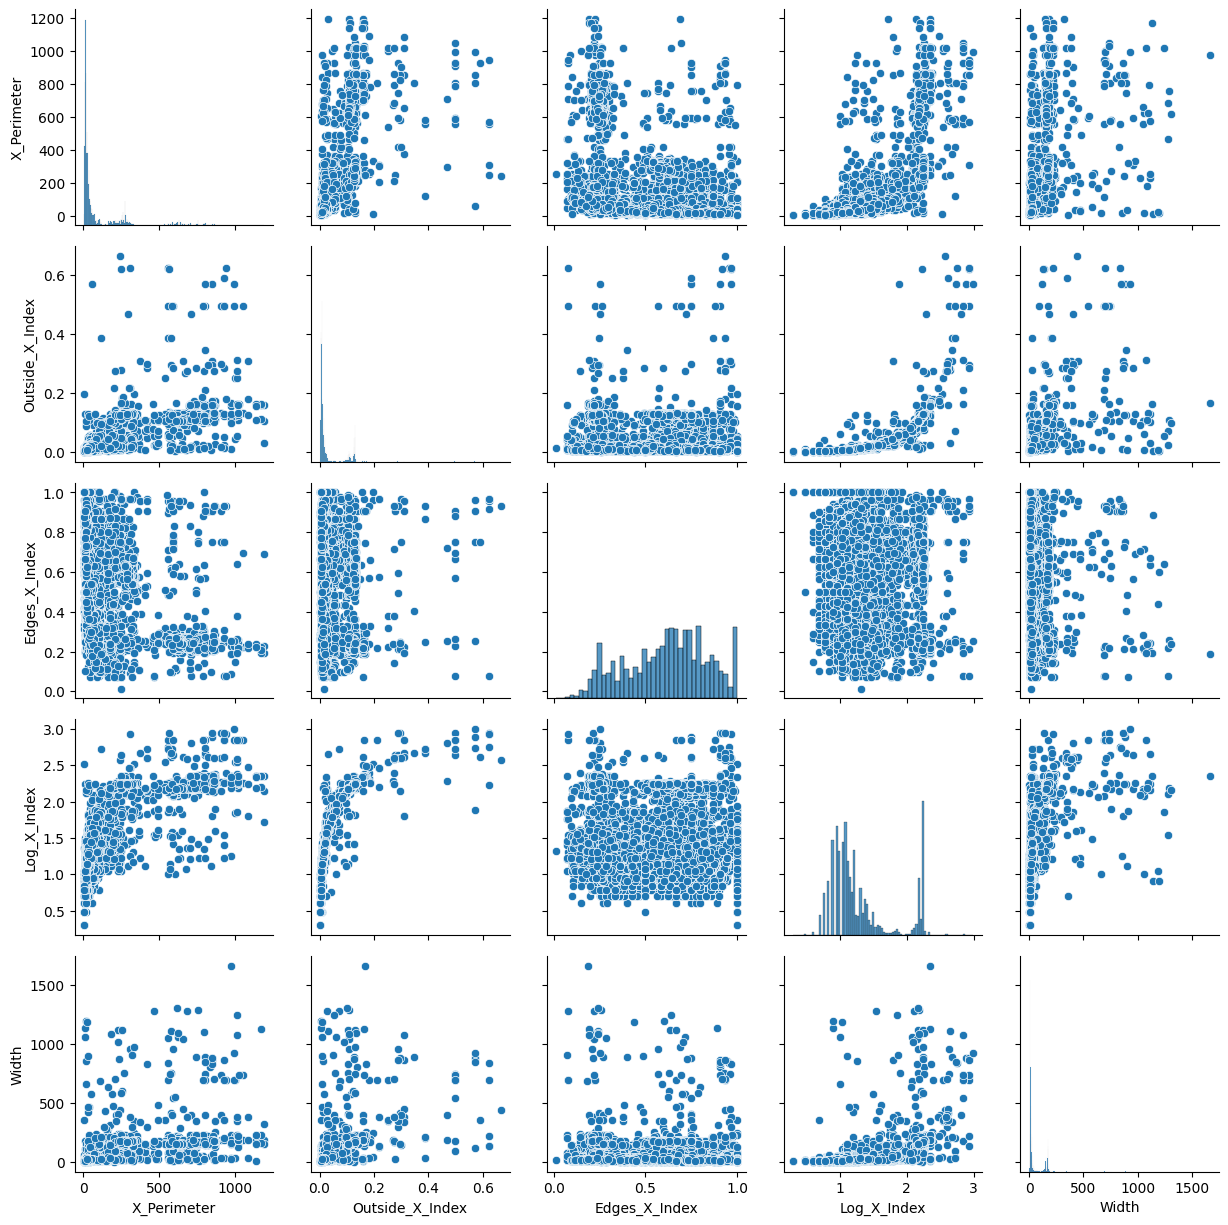

In [29]:
graph = sns.PairGrid(X_feats)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

The logarithmic relationship in `Log_X_Index` vs `Outside_X_Index` compels me to "unlog" `Log_X_Index`. However, judging from distributions alone, it seems like we'd benefit more from a logarithmic `Outside_X_Index`. Let's do the same for `Width` and `X_Perimeter` since their distributions suffer the same extreme skew.

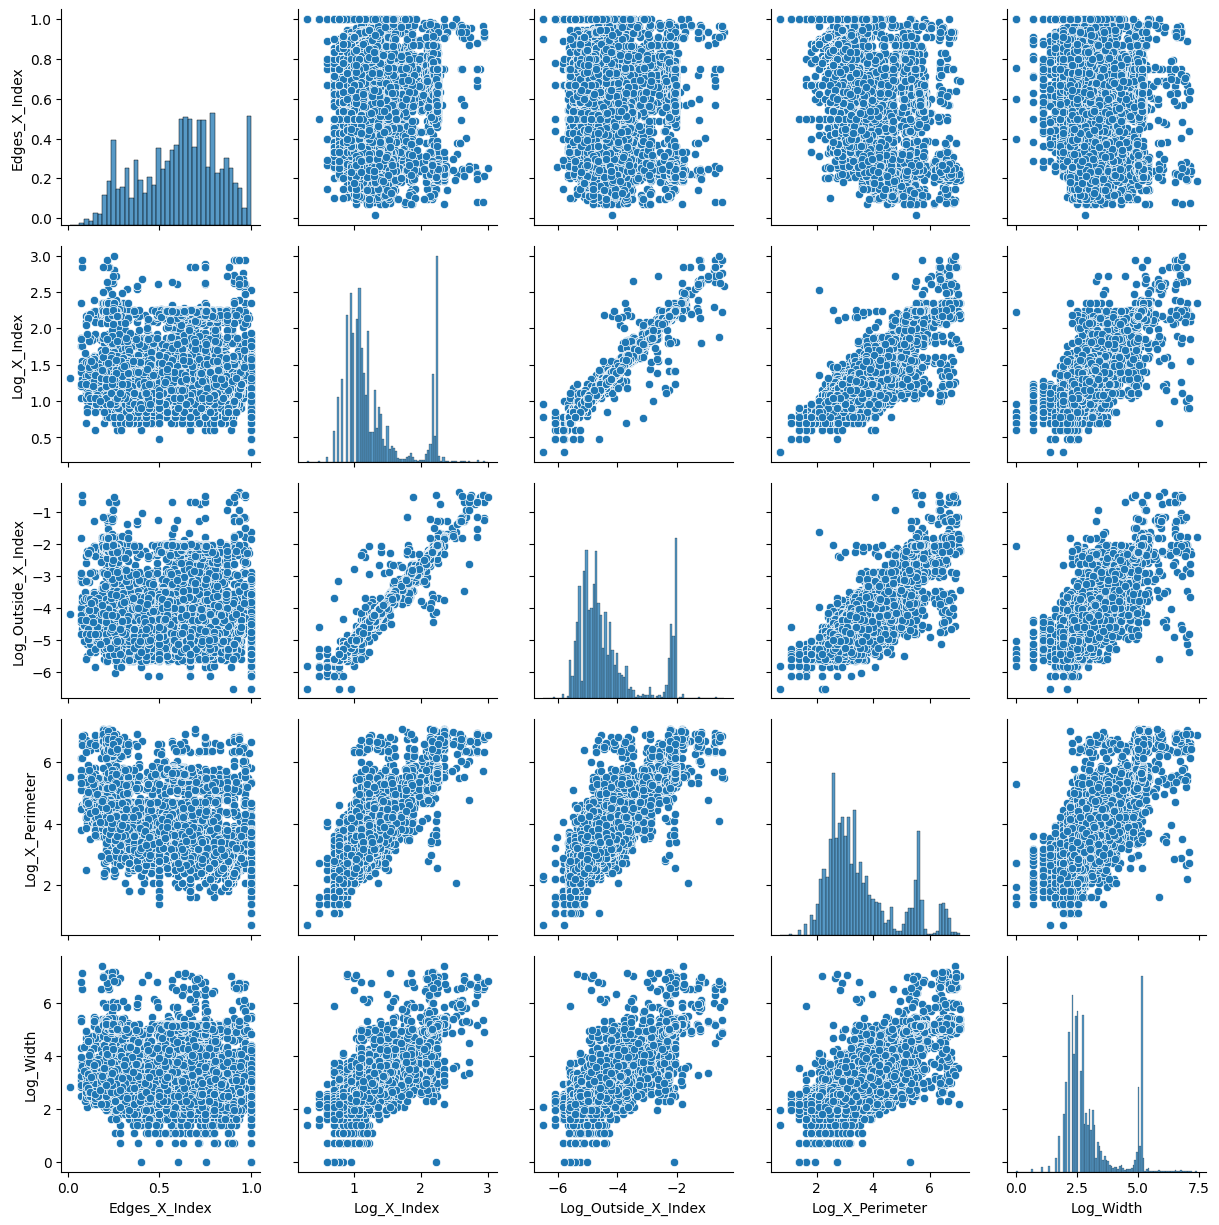

In [30]:
eps1 = 1e-6
eps2 = 1
temp_df = pd.DataFrame()
temp_df[['Edges_X_Index', 'Log_X_Index']
        ] = X_feats[['Edges_X_Index','Log_X_Index']]
temp_df[['Log_Outside_X_Index', 'Log_X_Perimeter'
         ]] = np.log(X_feats[['Outside_X_Index', 'X_Perimeter']] + eps1)
temp_df['Log_Width'] = np.log(X_feats['Width'] + eps2)
graph = sns.PairGrid(temp_df)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

`Log_X_Index` and `Log_Outside_X_Index` are very strongly correlated.

In [31]:
temp_df.corr()

Edges_X_Index  Log_X_Index  Log_Outside_X_Index  \
Edges_X_Index             1.000000    -0.205571            -0.210341   
Log_X_Index              -0.205571     1.000000             0.992640   
Log_Outside_X_Index      -0.210341     0.992640             1.000000   
Log_X_Perimeter          -0.496672     0.921012             0.920283   
Log_Width                -0.228289     0.922152             0.920764   

                     Log_X_Perimeter  Log_Width  
Edges_X_Index              -0.496672  -0.228289  
Log_X_Index                 0.921012   0.922152  
Log_Outside_X_Index         0.920283   0.920764  
Log_X_Perimeter             1.000000   0.879805  
Log_Width                   0.879805   1.000000

We'll keep `Edges_X_Index` and `Log_X_Index` and drop the rest. In summary, we're dropping from the dataset:
* `Y_Maximum`, `Y_Minimum`, `X_Maximum`, `X_Minimum`,
* `SigmoidOfAreas`, `Pixels_Areas`, 
* `Outside_X_Index`, `X_Perimeter`, `Y_Perimeter`.

This leaves us with:
* `Log_X_Index`, `Log_Y_Index`,
* `Edges_X_Index`, `Edges_X_Index`

### Other Geometric Variables

Namely, `Edges_Index`, `Empty_Index`, `Square_Index`, `Outside_Global_Index`, `Orientation_Index`.

In [32]:
cols = ['Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_Global_Index', 'Orientation_Index']
other_df = df[cols]

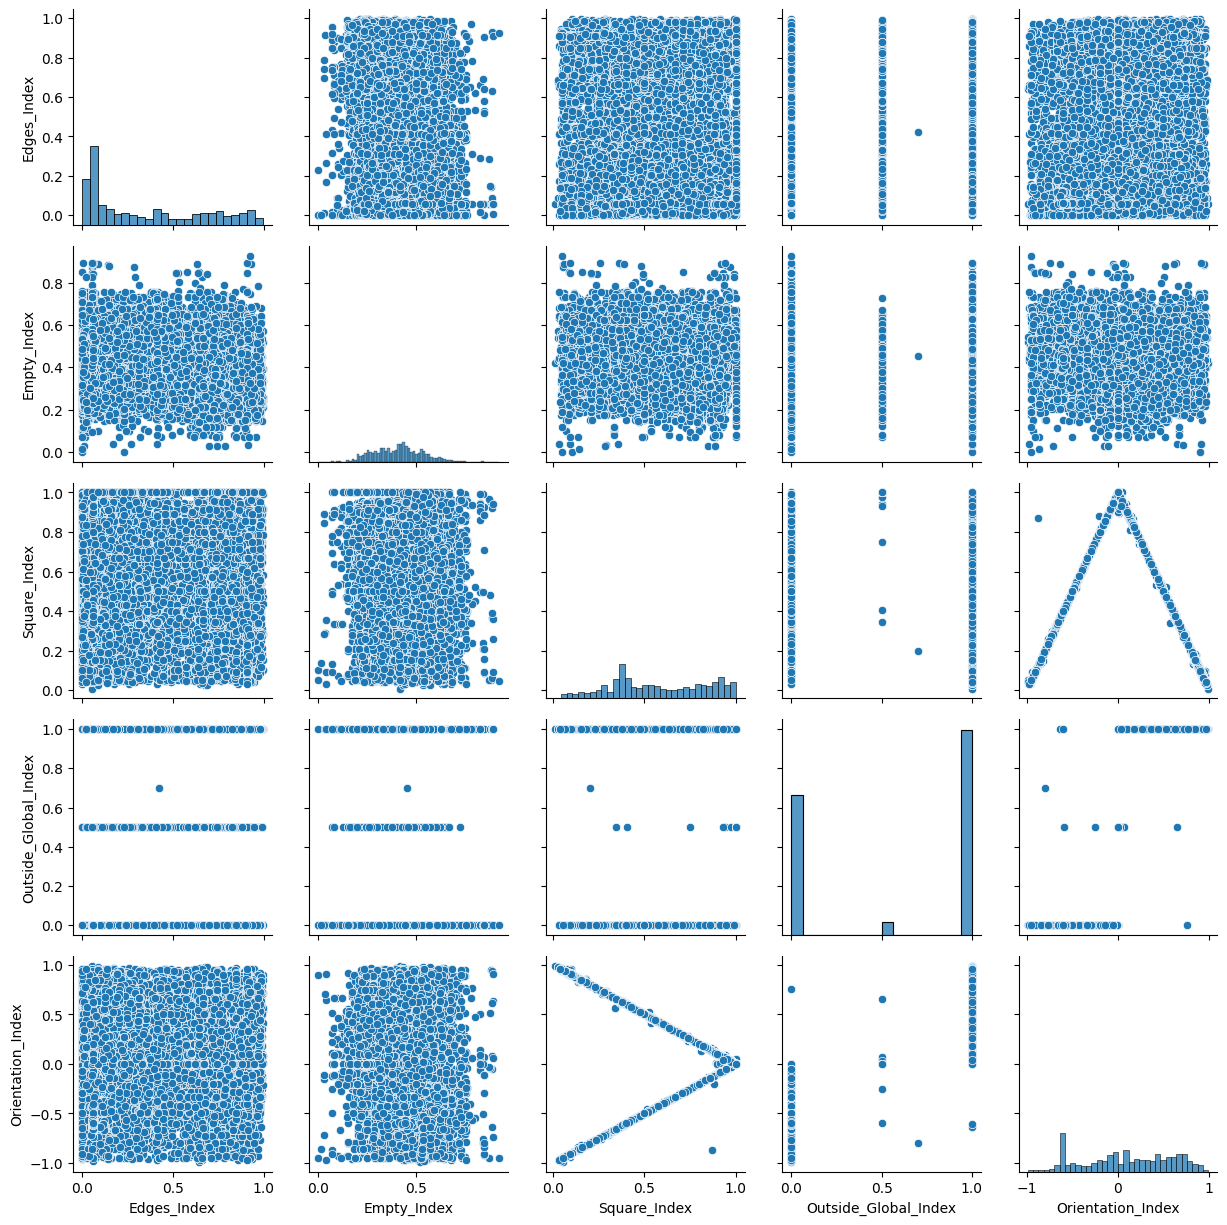

In [33]:
graph = sns.PairGrid(other_df)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

C:\Users\ttfee\AppData\Local\Temp\ipykernel_10756\1759500169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_df['Abs_Orientation'] = np.abs(other_df['Orientation_Index'])


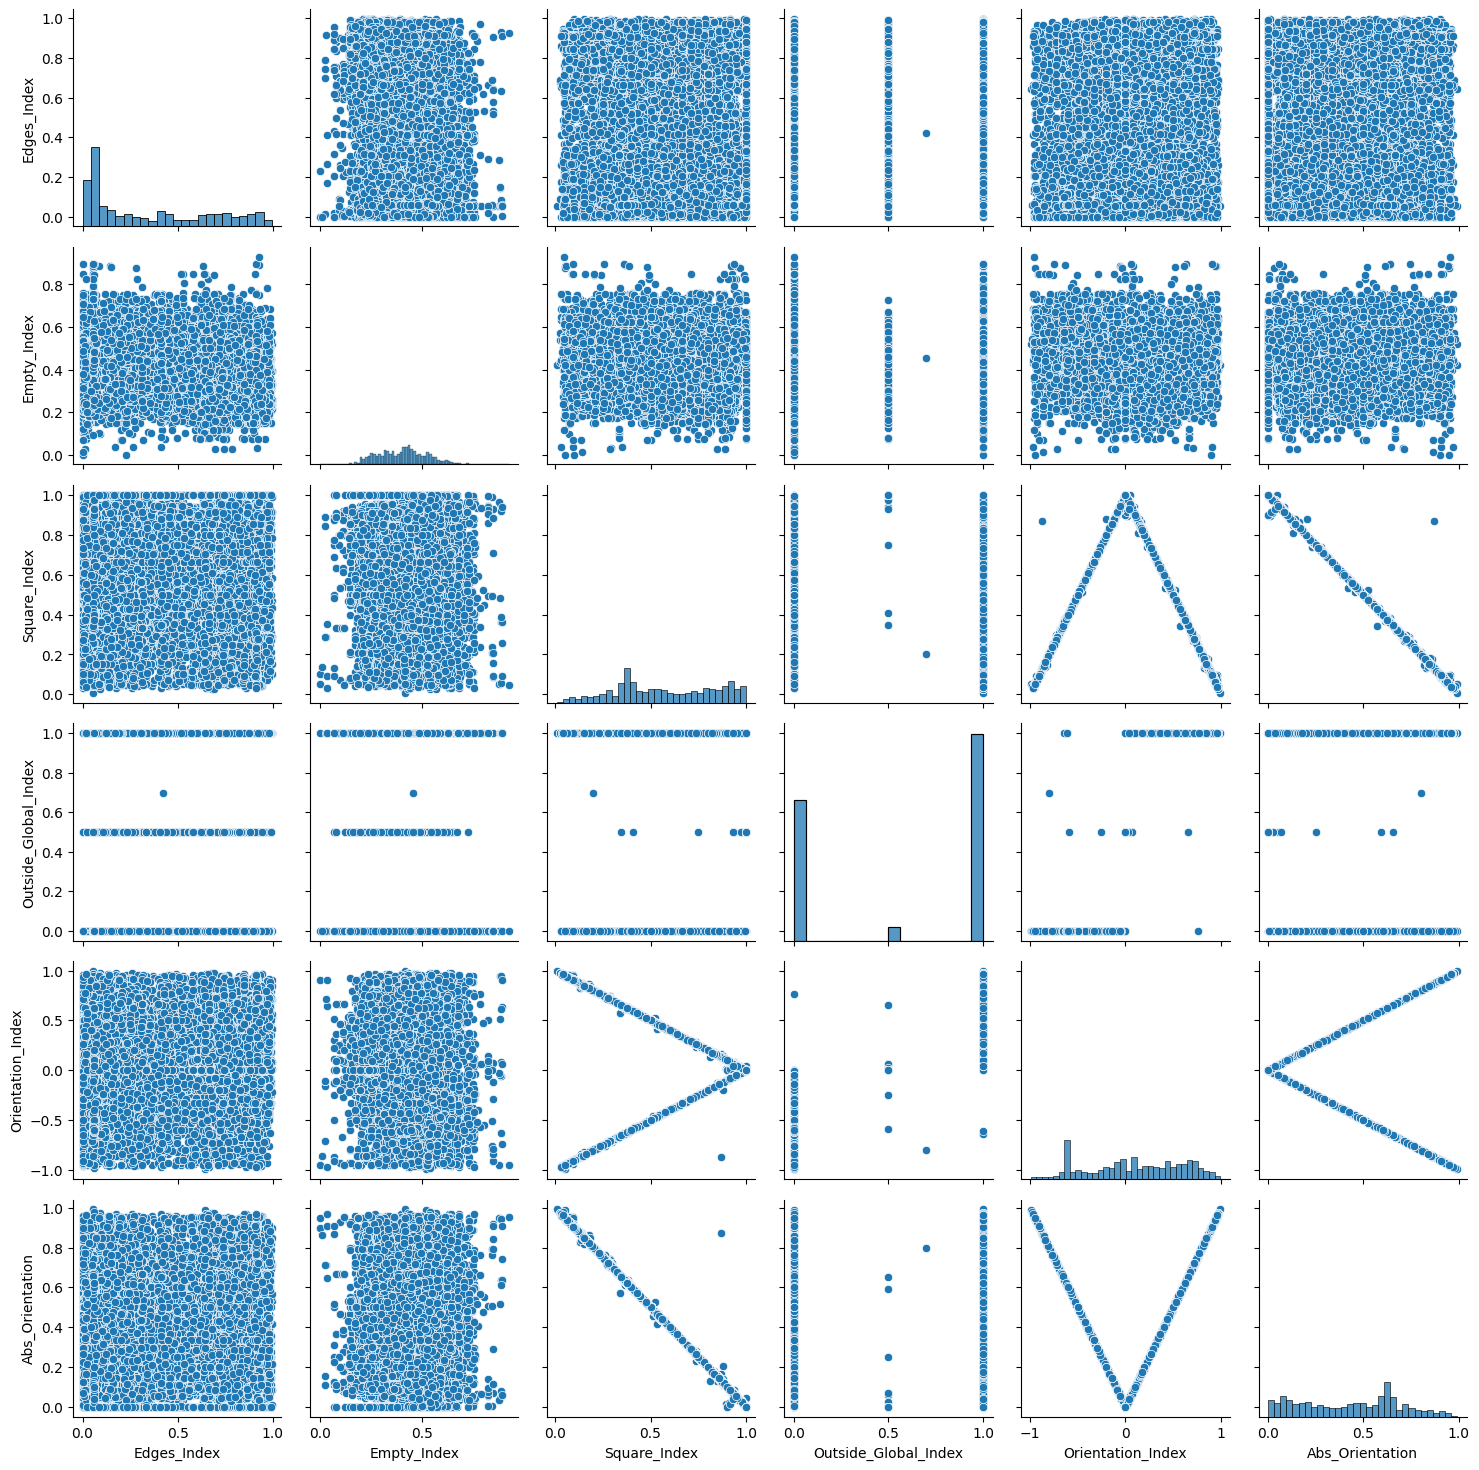

In [34]:
other_df['Abs_Orientation'] = np.abs(other_df['Orientation_Index'])
graph = sns.PairGrid(other_df)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

Since `Square_Index` seems to be just 1 - |`Orientation_Index`|, it's likely that `Orientation_Index` is the sine of the angle from a perfectly direct picture. The 'squareness' of the picture would then be 1 when perfectly square and zero when taken from the side. For this reason, `Abs_Orientation_Index` should replace both variables.

In [35]:
other_df = other_df.drop(columns=['Square_Index', 'Orientation_Index'])
other_df.corr()

Edges_Index  Empty_Index  Outside_Global_Index  \
Edges_Index              1.000000    -0.173891              0.048799   
Empty_Index             -0.173891     1.000000             -0.206096   
Outside_Global_Index     0.048799    -0.206096              1.000000   
Abs_Orientation         -0.121486     0.126603              0.099065   

                      Abs_Orientation  
Edges_Index                 -0.121486  
Empty_Index                  0.126603  
Outside_Global_Index         0.099065  
Abs_Orientation              1.000000

Let's investigate the effect of orientation normalizing.

In [36]:
temp_df = pd.DataFrame()
temp_df['N_Width'] = feature_df['Width']
temp_df['N_Height'] = feature_df['Height'] * other_df['Abs_Orientation']

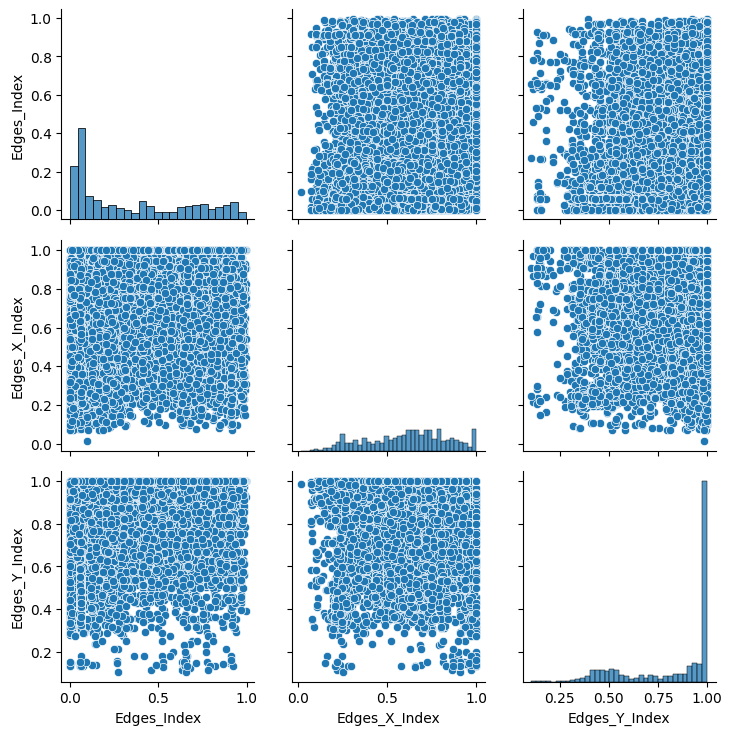

In [37]:
graph = sns.PairGrid(df[['Edges_Index', 'Edges_X_Index', 'Edges_Y_Index']])
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot)

## Exploring Non-Geometric Variables

In [38]:
feature_df['Log_Range'] = np.log(1 + feature_df['Maximum_of_Luminosity']) - np.log(1 + feature_df['Minimum_of_Luminosity'])
feature_df['Log_Lum'] = np.log(feature_df['Sum_of_Luminosity'])
feature_df['Binary_Conveyer_Length'] = (feature_df['Length_of_Conveyer'] > 1510).astype(int)
feature_df['Log_Avg_Lum'] = feature_df['Log_Lum'] - 2 * feature_df['LogOfAreas']
cols = ['Steel_Plate_Thickness', 'Luminosity_Index', 'Log_Range', 
        'Log_Lum', 'Binary_Conveyer_Length', 'Empty_Index', 'Log_Avg_Lum']
non_df = feature_df[cols]
non_df.describe().T

count       mean        std        min        25%  \
Steel_Plate_Thickness   19198.0  76.251693  53.948649  40.000000  40.000000   
Luminosity_Index        19198.0  -0.138416   0.120358  -0.885000  -0.192500   
Log_Range               19198.0   0.480568   0.404869  -0.322288   0.214775   
Log_Lum                 19198.0  10.395400   1.759076   5.521461   9.189219   
Binary_Conveyer_Length  19198.0   0.303730   0.459879   0.000000   0.000000   
Empty_Index             19198.0   0.409177   0.124096   0.000000   0.317500   
Log_Avg_Lum             19198.0   5.451477   0.470073  -1.036832   5.273834   

                              50%        75%         max  
Steel_Plate_Thickness   69.000000  80.000000  300.000000  
Luminosity_Index        -0.142700  -0.084000    0.642100  
Log_Range                0.315638   0.550831    4.905275  
Log_Lum                  9.810165  11.126535   16.265775  
Binary_Conveyer_Length   0.000000   1.000000    1.000000  
Empty_Index              0.413300   0.494475    0.927500  
Log_Avg_Lum              5.390019   5.584270   10.122959

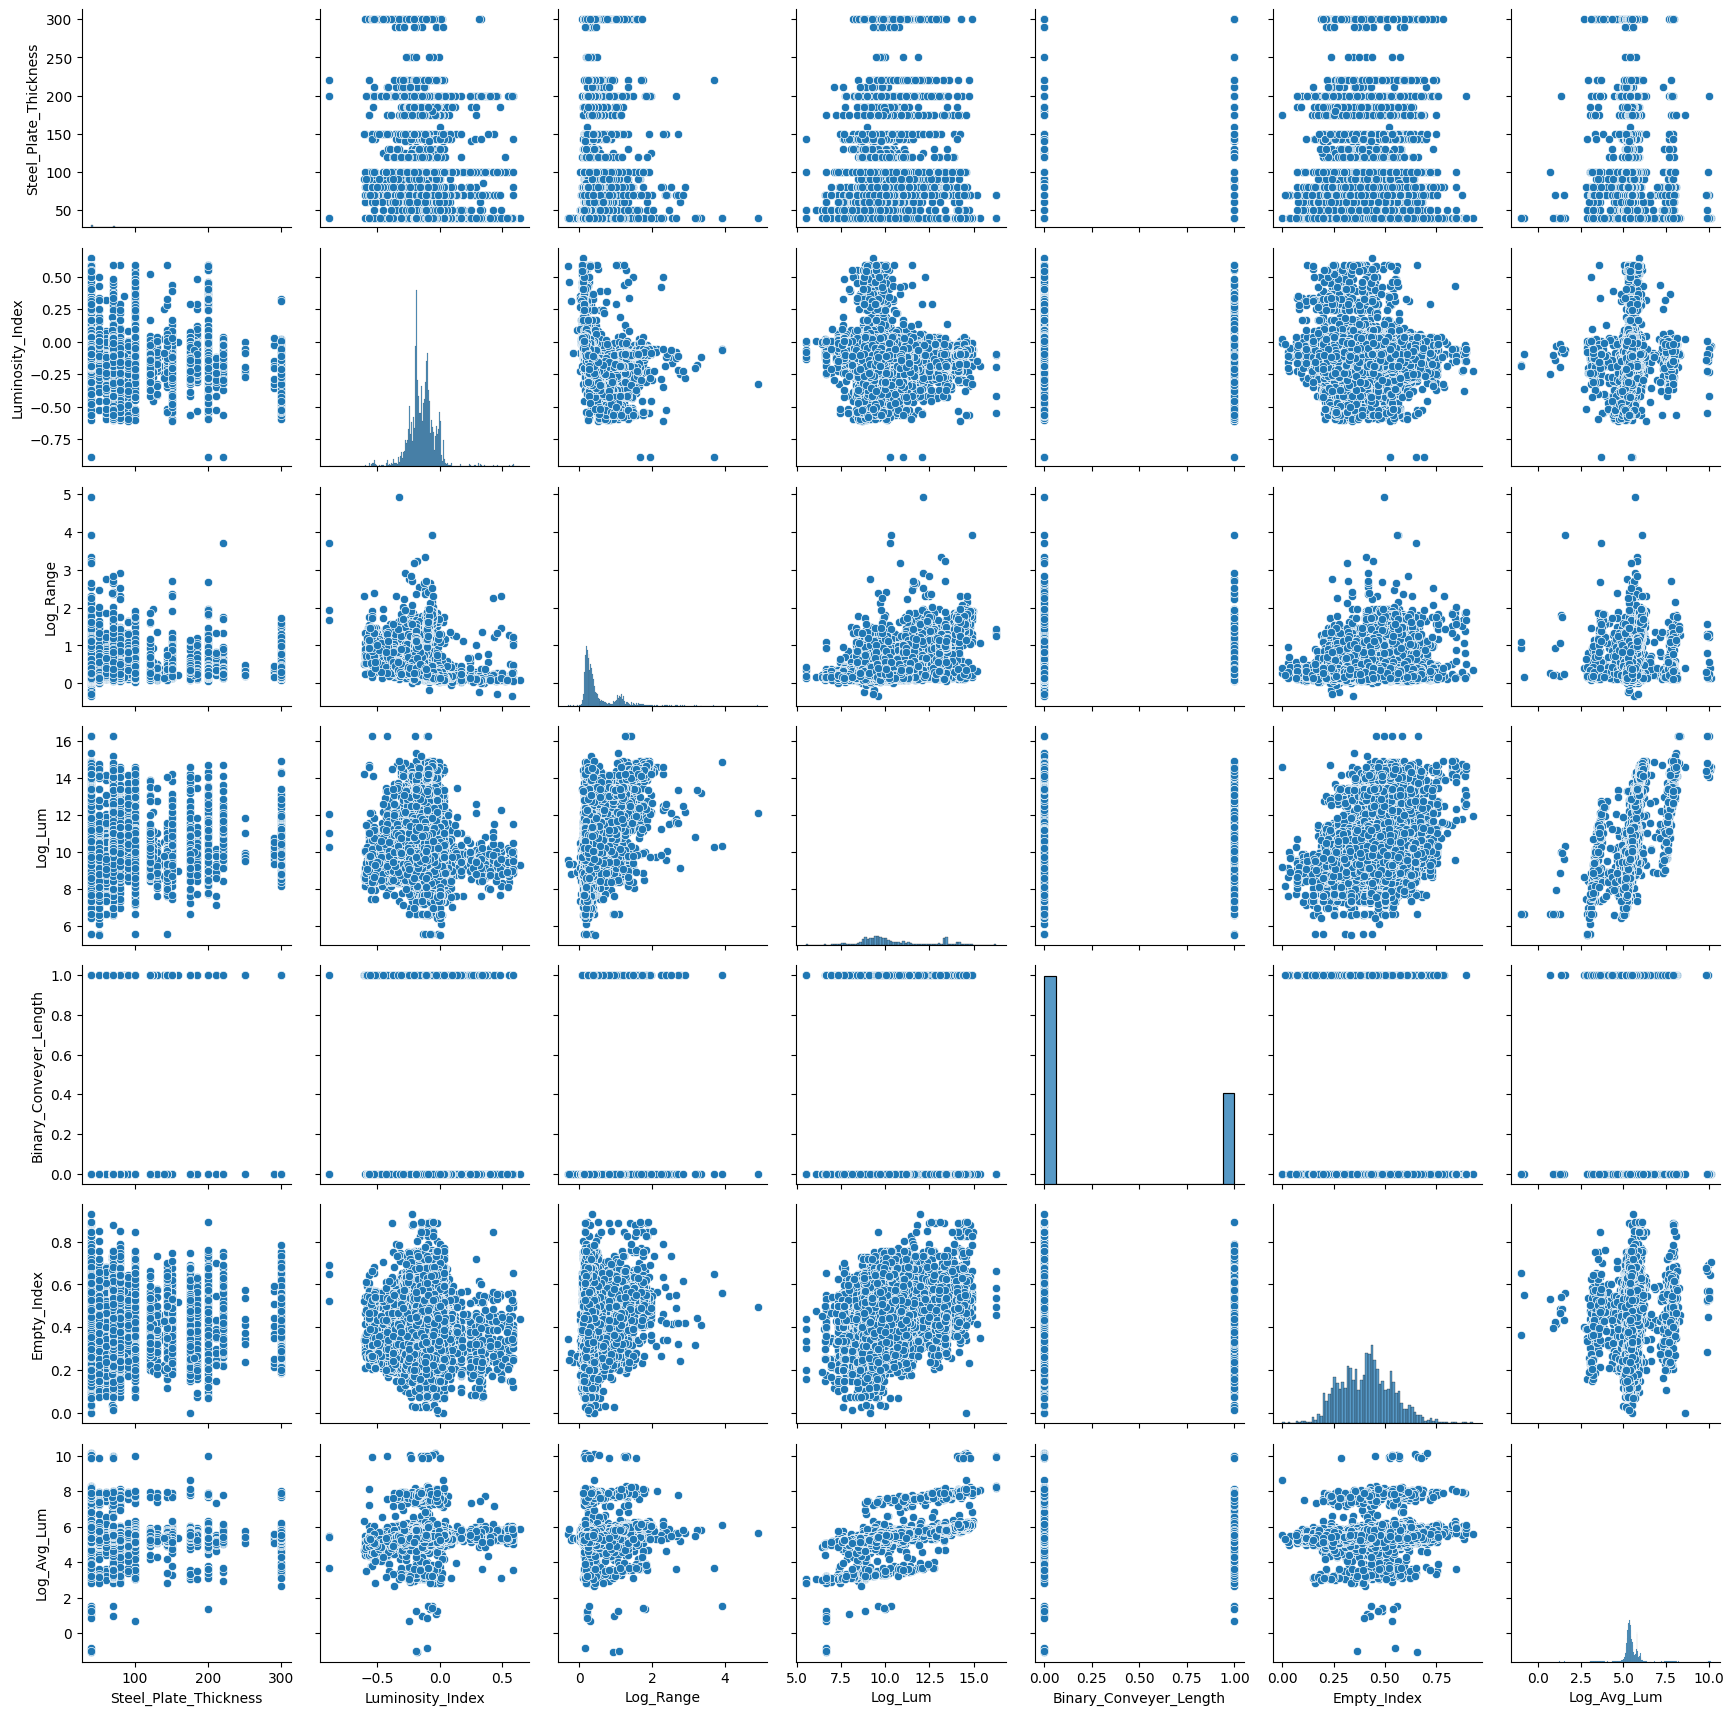

In [39]:
graph = sns.PairGrid(non_df)
graph.map_diag(sns.histplot, stat='density')
graph.map_offdiag(sns.scatterplot)

## Correlation Map with New Features

In [40]:
cols = ['LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
        'Edges_Index', 'Outside_Global_Index', 'Abs_Orientation',
        'Steel_Plate_Thickness', 'Luminosity_Index', 
        'Log_Avg_Lum', 'Length_of_Conveyer', 'Empty_Index', 'Norm_Range']
feature_df['Abs_Orientation'] = np.abs(feature_df['Orientation_Index'])
feature_df['Norm_Range'] = feature_df['Log_Range'] - feature_df['LogOfAreas']/2
final_df = feature_df[cols]

LogOfAreas  Log_X_Index  Log_Y_Index  Edges_Index  \
LogOfAreas               1.000000     0.888016     0.878776    -0.419594   
Log_X_Index              0.888016     1.000000     0.666926    -0.383062   
Log_Y_Index              0.878776     0.666926     1.000000    -0.372720   
Edges_Index             -0.419594    -0.383062    -0.372720     1.000000   
Outside_Global_Index    -0.170116    -0.437968     0.127324     0.048799   
Abs_Orientation          0.237764     0.113835     0.325487    -0.121486   
Steel_Plate_Thickness   -0.201462    -0.267130    -0.093349     0.085111   
Luminosity_Index        -0.134227    -0.058816    -0.158108     0.213657   
Log_Avg_Lum              0.396992     0.416723     0.364082    -0.139780   
Length_of_Conveyer      -0.254937    -0.288035    -0.195048     0.075518   
Empty_Index              0.378347     0.420723     0.359247    -0.173891   
Norm_Range              -0.254728    -0.147644    -0.279985     0.023593   

                       Outside_Global_Index  Abs_Orientation  \
LogOfAreas                        -0.170116         0.237764   
Log_X_Index                       -0.437968         0.113835   
Log_Y_Index                        0.127324         0.325487   
Edges_Index                        0.048799        -0.121486   
Outside_Global_Index               1.000000         0.099065   
Abs_Orientation                    0.099065         1.000000   
Steel_Plate_Thickness              0.201093         0.047764   
Luminosity_Index                  -0.115880        -0.082485   
Log_Avg_Lum                       -0.135855         0.089356   
Length_of_Conveyer                 0.182908        -0.094266   
Empty_Index                       -0.206096         0.126603   
Norm_Range                        -0.037314        -0.286111   

                       Steel_Plate_Thickness  Luminosity_Index  Log_Avg_Lum  \
LogOfAreas                         -0.201462         -0.134227     0.396992   
Log_X_Index                        -0.267130         -0.058816     0.416723   
Log_Y_Index                        -0.093349         -0.158108     0.364082   
Edges_Index                         0.085111          0.213657    -0.139780   
Outside_Global_Index                0.201093         -0.115880    -0.135855   
Abs_Orientation                     0.047764         -0.082485     0.089356   
Steel_Plate_Thickness               1.000000         -0.101933    -0.126117   
Luminosity_Index                   -0.101933          1.000000     0.115508   
Log_Avg_Lum                        -0.126117          0.115508     1.000000   
Length_of_Conveyer                  0.243110         -0.210432    -0.171623   
Empty_Index                        -0.061076          0.085339     0.224746   
Norm_Range                         -0.023308         -0.226409    -0.105057   

                       Length_of_Conveyer  Empty_Index  Norm_Range  
LogOfAreas                      -0.254937     0.378347   -0.254728  
Log_X_Index                     -0.288035     0.420723   -0.147644  
Log_Y_Index                     -0.195048     0.359247   -0.279985  
Edges_Index                      0.075518    -0.173891    0.023593  
Outside_Global_Index             0.182908    -0.206096   -0.037314  
Abs_Orientation                 -0.094266     0.126603   -0.286111  
Steel_Plate_Thickness            0.243110    -0.061076   -0.023308  
Luminosity_Index                -0.210432     0.085339   -0.226409  
Log_Avg_Lum                     -0.171623     0.224746   -0.105057  
Length_of_Conveyer               1.000000    -0.252577    0.178106  
Empty_Index                     -0.252577     1.000000   -0.274252  
Norm_Range                       0.178106    -0.274252    1.000000

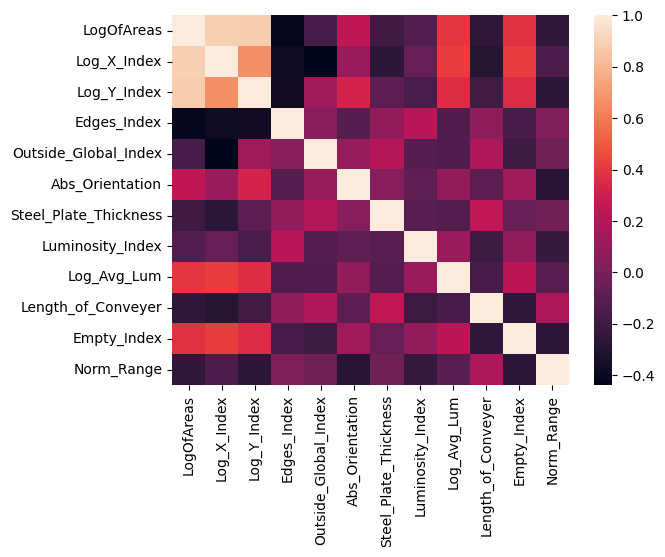

In [41]:
corr = final_df.corr()
sns.heatmap(corr)
display(corr)

## K Means Clustering

In [42]:
stats = final_df.describe().T[['mean', 'std']]
df_normed = (final_df - stats['mean']) / stats['std']
df_normed.describe().T[['mean', 'std']]

mean  std
LogOfAreas             2.287298e-16  1.0
Log_X_Index           -1.413831e-16  1.0
Log_Y_Index           -9.845003e-17  1.0
Edges_Index           -1.465647e-16  1.0
Outside_Global_Index  -1.473049e-16  1.0
Abs_Orientation       -3.060834e-16  1.0
Steel_Plate_Thickness -8.679147e-17  1.0
Luminosity_Index       1.684014e-17  1.0
Log_Avg_Lum           -1.122182e-15  1.0
Length_of_Conveyer    -5.688635e-16  1.0
Empty_Index            5.089052e-17  1.0
Norm_Range            -2.735134e-16  1.0

20
40
60
80
100
120
140
160
180
200


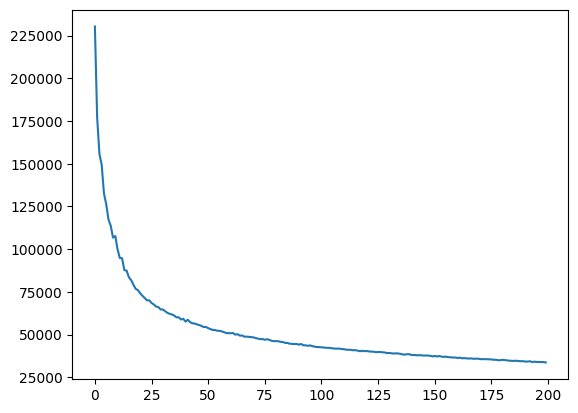

In [43]:
from sklearn.cluster import KMeans

cluster_range = 200

inertias = []

for num in range(1, cluster_range+1):
    if num % 20 == 0: print(num)
    kmeans = KMeans(n_clusters=num).fit(df_normed)
    inertias.append(kmeans.inertia_)

plt.plot(inertias)
plt.show()

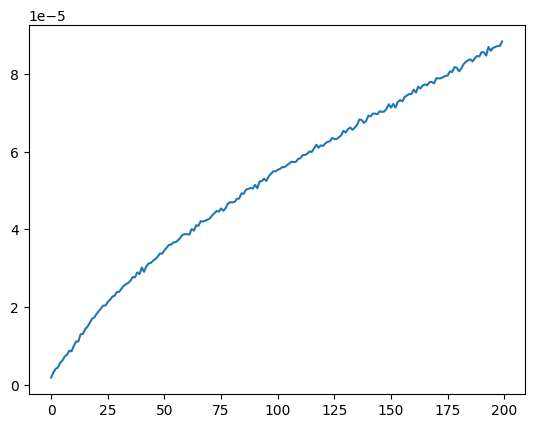

In [53]:
plt.plot(np.power(inertias, -2) * 100_000)
plt.show()

## PCA

In [54]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_normed)
print(pca.explained_variance_ratio_)

[0.31063143 0.13654513 0.11823184 0.07691209 0.07292984 0.06288969
 0.05800666 0.05649418 0.05101484 0.04238016 0.01089456 0.00306957]


## Importance of Variations

In [55]:
df = pd.read_csv(paths.TRAIN)
y_cols = df.columns[-7:]

df['Log_Range'] = np.log(1 + df['Maximum_of_Luminosity']) - np.log(1 + df['Minimum_of_Luminosity'])
df['Abs_Orientation'] = np.abs(df['Orientation_Index'])
df['Norm_Range'] = df['Log_Range'] - df['LogOfAreas']/2

df['Log_Lum'] = np.log(df['Sum_of_Luminosity'])
df['Log_Avg_Lum'] = df['Log_Lum'] - 2 * df['LogOfAreas']

X_cols = ['LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
        'Edges_Index', 'Outside_Global_Index', 'Abs_Orientation',
        'Steel_Plate_Thickness', 'Luminosity_Index', 
        'Log_Avg_Lum', 'Length_of_Conveyer', 'Empty_Index', 'Norm_Range']

pca_feats = [f'feature_{i}' for i in range(1, 12 + 1)]

X_feats = df[X_cols]
stats = X_feats.describe().T
X_normed = (X_feats - stats['mean']) / stats['std']

df[pca_feats] = pca.transform(X_normed)

In [56]:
y = df[y_cols]
X = df[pca_feats+X_cols]
ids = df['id']

In [57]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

trains = []
valids = []
for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, ids)):
    print(f'Fold: {fold}')
    train_X = X.loc[train_index]
    train_y = y.loc[train_index]
    valid_X = X.loc[valid_index]
    valid_y = y.loc[valid_index]
    trains.append((train_X, train_y))
    valids.append((valid_X, valid_y))

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 5
lr = 0.05

xgboosts = []
aucs = np.zeros(7)

for fold in range(5):
    print(f'Fold: {fold}')

    # Fit Model
    model = XGBClassifier(n_estimators=estimators,
                          early_stopping_rounds=stopping,
                          learning_rate=lr,
                          n_jobs=4)
    model.fit(*trains[fold], 
              eval_set=[valids[fold]], verbose=0)
    xgboosts.append(model)

    # Calculate ROCS
    X_val, y_val = valids[fold]
    preds = model.predict_proba(X_val)
    aucs += np.array(roc_auc_score(y_val, preds, multi_class='ovr', average=None))
    
val_aucs = pd.Series(aucs, index=y_cols)/5
display(val_aucs)
print(f'Mean AUC: {round(val_aucs.mean(), 4)}')

print('\n'+'='*30)
print('Importances')
print('='*30)

importances = xgboosts[0].feature_importances_
for xgboost in xgboosts[1:]:
    importances += xgboost.feature_importances_
importances = np.array(importances) / 5
Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
sortd = np.sort(importances)[::-1]
for i, col in enumerate(Xcols):
    print(f'{col}: {sortd[i]:.2f}')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


Pastry          0.853956
Z_Scratch       0.954922
K_Scatch        0.984114
Stains          0.991254
Dirtiness       0.864284
Bumps           0.801127
Other_Faults    0.700139
dtype: float64

Mean AUC: 0.8785

Importances
Log_X_Index: 0.26
Outside_Global_Index: 0.17
LogOfAreas: 0.12
Steel_Plate_Thickness: 0.08
Length_of_Conveyer: 0.05
feature_2: 0.03
Log_Y_Index: 0.03
Abs_Orientation: 0.02
feature_3: 0.02
feature_7: 0.02
Edges_Index: 0.02
feature_4: 0.02
Luminosity_Index: 0.02
feature_1: 0.02
feature_11: 0.02
Norm_Range: 0.02
feature_6: 0.01
Empty_Index: 0.01
feature_5: 0.01
feature_10: 0.01
feature_9: 0.01
feature_8: 0.01
Log_Avg_Lum: 0.01
feature_12: 0.01


In [71]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

estimators = 1000
stopping = 20
lr = 0.05

aucs = pd.Series()

for i, col in enumerate(y_cols):
    print('='*30)
    print(col)
    print('='*30)
    xgboosts=[]
    aucs_sum = 0
    for fold in range(5):
        
        X, y = trains[fold]
        y_col = np.array(y[col])
        X_val, y_val = valids[fold]
        y_val_col = np.array(y_val[col])

        # Fit Model

        model = XGBClassifier(n_estimators=estimators,
                              early_stopping_rounds=stopping,
                              learning_rate=lr,
                              n_jobs=4,
                              eval_metric='auc')

        model.fit(X, y_col, eval_set=
                  [(X_val, np.array(y_val[col]))], verbose=0)
        xgboosts.append(model)

        # Calculate ROCS
        preds = model.predict_proba(X_val)[:,1]
        aucs_sum += roc_auc_score(np.array(y_val[col]), preds)

    aucs[col] = aucs_sum / 5
    # Importances
    importances = xgboosts[0].feature_importances_
    for xgboost in xgboosts[1:]:
        importances += xgboost.feature_importances_
    importances = np.array(importances) / 5
    Xcols = np.array(X.columns)[np.argsort(importances)][::-1]
    sortd = np.sort(importances)[::-1]
    for i, clm in enumerate(Xcols):
        print(f'{clm}: {sortd[i]:.3f}')

display(aucs)
print(f'Mean AUC: {aucs.mean():.4f}')

Pastry
Outside_Global_Index: 0.329
feature_2: 0.127
Log_X_Index: 0.044
feature_4: 0.039
feature_6: 0.039
feature_11: 0.037
Steel_Plate_Thickness: 0.029
Length_of_Conveyer: 0.029
Abs_Orientation: 0.027
Norm_Range: 0.024
Empty_Index: 0.024
Luminosity_Index: 0.022
feature_10: 0.022
LogOfAreas: 0.022
feature_9: 0.022
feature_3: 0.021
feature_5: 0.020
Log_Avg_Lum: 0.018
Edges_Index: 0.018
Log_Y_Index: 0.018
feature_1: 0.018
feature_12: 0.017
feature_7: 0.017
feature_8: 0.016
Z_Scratch
Steel_Plate_Thickness: 0.281
Length_of_Conveyer: 0.246
Outside_Global_Index: 0.029
feature_1: 0.028
Log_X_Index: 0.028
feature_9: 0.025
Edges_Index: 0.025
Empty_Index: 0.024
Norm_Range: 0.023
feature_6: 0.023
LogOfAreas: 0.021
feature_10: 0.020
feature_8: 0.020
feature_12: 0.020
Luminosity_Index: 0.020
feature_2: 0.020
Log_Y_Index: 0.019
feature_3: 0.019
feature_7: 0.019
feature_11: 0.018
feature_5: 0.018
Abs_Orientation: 0.018
feature_4: 0.018
Log_Avg_Lum: 0.017
K_Scatch
Log_X_Index: 0.587
LogOfAreas: 0.140
S

Pastry          0.855019
Z_Scratch       0.955309
K_Scatch        0.984321
Stains          0.991074
Dirtiness       0.865922
Bumps           0.801990
Other_Faults    0.703415
dtype: float64

Mean AUC: 0.8796
